In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install catboost

In [ ]:
# We start by importing the libraries that we will need in the following code 
import pandas as pd  
import numpy as np  
import seaborn as sns
import math
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn import metrics
import scipy
import lightgbm
import statistics
import datetime as dt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**In this part we import the data from the csv file, process it so that it can be interpreted by the code and apply the appropriate regressors.** 

In [ ]:
# We read the training and test data 
data = pd.read_csv("/content/data_6.csv",encoding='latin-1',sep=';')
data_test=pd.read_csv("/content/test_6.csv",encoding='latin-1',sep=';')

In [ ]:
#Remove columns with many empty cells or repeated columns 
data=data.drop(columns=['Mos.','Grp.Crop','birth.day','second.feed.1.date','second.feed..2.date'])
data_test=data_test.drop(columns=['Mos.','Grp.Crop','birth.day','second.feed.1.date','second.feed..2.date'])

In [ ]:
#In this code cell we make a text treatment of the data by replacing the spaces, normalize the texts to avoid the redundancy and convert the whole after in type Float
columns=data.columns
columns_test=data_test.columns

for i in range(0,len(columns)):
  try:
    data[columns[i]]=data[columns[i]].str.replace(' ','')
  except:
    pass
for i in range(0,len(columns_test)):
  try:
    data_test[columns_test[i]]=data_test[columns_test[i]].str.replace(' ','')
  except:
    pass
for i in range(0,len(columns)):
  try:
    data[columns[i]]=data[columns[i]].str.capitalize()
  except:
    pass
for i in range(0,len(columns)):
  try:
    data_test[columns_test[i]]=data_test[columns_test[i]].str.capitalize()
  except:
    pass
for i in range(1,len(columns)):
  try:
    data[columns[i]]=data[columns[i]].astype(float)
  except:
    pass
for i in range(1,len(columns)):
  try:
    data_test[columns_test[i]]=data_test[columns_test[i]].astype(float)
  except:
    pass

In [ ]:
#We replace the empty cells of the data represented by - by np.nan then by the mean of each column 
data=data.replace(159753,np.nan) # It is noted that a manipulation on excel was made to replace the - by a number (159753)
data_test=data_test.replace(159753,np.nan)

data=data.replace(np.nan,data.mean(skipna=True))
data_test=data_test.replace(np.nan,data_test.mean(skipna=True))

In [ ]:
#We parse the dates of the data in datetime and we make a mapping 

data['sampling.date']= pd.to_datetime(data['sampling.date'])
data_test['sampling.date']= pd.to_datetime(data_test['sampling.date'])

data['sampling.date']=data['sampling.date'].map(dt.datetime.toordinal)
data_test['sampling.date']=data_test['sampling.date'].map(dt.datetime.toordinal)

In [ ]:
#We factor the columns whose values are presented as groups 
data = pd.get_dummies(data, columns=['Sampling.Timing.Vs.second.feed.timing','second.feed..2','Province','Agroecological.zones','Crop','Regime','Code_Stage','Base.Feed','Second.feed.1'])
data_test = pd.get_dummies(data_test, columns=['Sampling.Timing.Vs.second.feed.timing','second.feed..2','Province','Agroecological.zones','Crop','Regime','Code_Stage','Base.Feed','Second.feed.1'])

In [ ]:
# In the column PROVINCE some provinces are not present in the test data so we add them factorized then parse them into uint8
M=[0]*238
data_test['Province_Elkelaadessraghna']=M
data_test["Province_M'diq159753fnideq"]=M
data_test['Province_Rehamna']=M
data_test['Province_Elkelaadessraghna']=data_test['Province_Elkelaadessraghna'].astype(np.uint8)
data_test["Province_M'diq159753fnideq"]=data_test["Province_M'diq159753fnideq"].astype(np.uint8)
data_test['Province_Rehamna']=data_test['Province_Rehamna'].astype(np.uint8)

In [ ]:
#We define a certain order of the data 
columns=list(data.columns)
columns.sort()
data=data[columns]
columns_test=list(data_test.columns)
columns_test.sort()
data_test=data_test[columns_test]

In [ ]:
#We take a global look at the data 
data.describe()

,AI,Agroecological.zones_Défavorable,Agroecological.zones_Favorable,Agroecological.zones_Favorablesupérieur,Agroecological.zones_Interemédiaire,Agroecological.zones_Montagne,B1,B2,B3,B4,B5,B6,B6_VCID_1,B6_VCID_2,B7,Base.Feed_No,Base.Feed_Yes,Code_Stage_S1,Code_Stage_S2,Column1,Crop_Avoine,Crop_Blédur,Crop_Blétendre,Crop_Orge,ETP_jan_mars,ETP_oct_dec,ETP_oct_mars,EVI_Diff,EVI_RUE,EVI_fev,EVI_jan,EVI_jan_mars,EVI_mars,EVI_max,EVI_min,EVI_oct_dec,EVI_oct_mars,EVIsum,Ec,FAPAR_RUE,...,Province_Meknès,Province_Myyaacoub,Province_Ouezzane,Province_Rehamna,Province_Safi,Province_Sefrou,Province_Settat,Province_Sidibennour,Province_Sidikacem,Province_Sidislimane,Province_Tanger159753assilah,Province_Taounate,Province_Taza,Province_Tétouan,Regime_Bour,Regime_Irrigué,Sampling.Timing.Vs.second.feed.timing_After,Sampling.Timing.Vs.second.feed.timing_Befor,Sampling.Timing.Vs.second.feed.timing_Nontopdress,Sampling.Timing.Vs.second.feed.timing_Noseconden,Second.feed.1_No,Second.feed.1_Yes,Target,X1,X10,X11,X12,X13,X2,X3,X4,X5,X6,X7,X8,X9,pH,sampling.date,second.feed..2_No,second.feed..2_Yes
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.00000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,...,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.00000,2096.000000,2096.000000,2096.000000
mean,2.327358,0.110687,0.295324,0.178912,0.312023,0.103053,575.020268,909.989172,924.005051,3607.147866,2292.055338,3353.090013,334.361281,334.358831,1396.967306,0.236641,0.763359,0.443702,0.556298,1167.260019,0.017176,0.234256,0.450859,0.29771,2277.479494,260.179865,615.592334,-0.315305,1.263908,0.416961,0.381651,0.393754,0.364153,0.463821,0.148526,0.215895,0.324537,3.500533,0.261161,3.801832,...,0.044847,0.018130,0.029103,0.019561,0.041031,0.007156,0.064885,0.034351,0.041985,0.028149,0.013836,0.053912,0.044847,0.010496,0.415553,0.051050,0.248569,0.021947,0.410305,0.319179,0.410305,0.589695,2.803106,0.149462,0.353569,0.346682,0.379159,0.131976,0.001965,0.227818,0.138856,0.119893,0.117756,0.103572,0.147371,0.293319,9.48029,737726.352099,0.992366,0.007634
std,0.936159,0.313819,0.456297,0.383370,0.463430,0.304101,223.813042,335.408622,524.803199,824.552735,742.423854,46.058142,5.172099,5.182101,718.325977,0.425122,0.425122,0.496939,0.496939,673.130605,0.129956,0.423634,0.497698,0.45736,257.132801,60.808106,110.952830,0.148825,0.420790,0.135508,0.119700,0.123327,0.137441,0.145003,0.053797,0.092296,0.103739,0.947760,0.209908,1.148592,...,0.207018,0.133453,0.168136,0.138519,0.198408,0.084313,0.246382,0.182173,0.200602,0.165437,0.116837,0.225898,0.207018,0.101936,0.492935,0.220151,0.432286,0.146544,0.492006,0.466270,0.492006,0.492006,1.079589,0.024371,0.083253,0.082170,0.088179,0.037156,0.001168,0.076927,0.072268,0.028343,0.033717,0.057638,0.054604,0.062456,0.40471,197.646595,0.087057,0.087057
min,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,151.680000,250.130000,132.830000,227.130000,89.760000,3145.250000,306.140000,306.540000,35.080000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1437.610000,32.320000,254.040000,-0.790000,0.000000,-0.020000,0.080000,-0.010000,-0.020000,-0.010000,-0.060000,-0.030000,-0.010000,0.000000,0.000000,0.800000,...,0.000000,0.000000,0.000000,0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Columns: 154 entries, AI to second.feed..2_Yes
dtypes: float64(94), int64(2), uint8(58)
memory usage: 1.7 MB


In order to have a better prediction we will try to reduce the number of columns by calculating some soil indicators 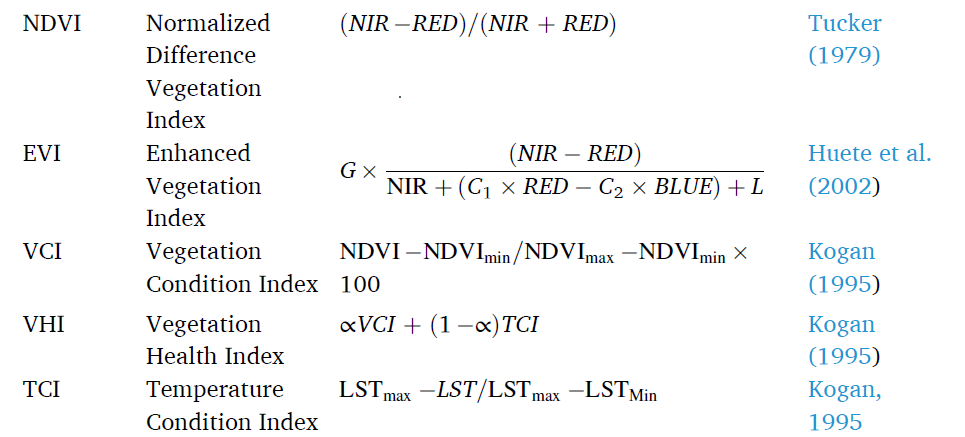
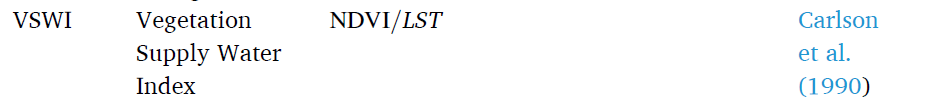
Source : https://reader.elsevier.com/reader/sd/pii/S1470160X20309729?token=89B25AE7E53EBBB80D34AB86C7ECDE8487597A711142CA24C3A6E4E050E3B2AFC3024DBAA1A5158774B5CC81B92DE2C0&originRegion=eu-west-1&originCreation=20220114142410

In [ ]:
def add_features(data):
  #Vegetation Condition Index
  data['VCI']=((data['NDVI']-data['NDVI_min'])/(data['NDVI_max']-data['NDVI_min']))*100
  data['VCI']=data['VCI'].astype(float)

  data['VCI']=data['VCI'].replace(np.nan,data['VCI'].mean())
  data['VCI']=data['VCI'].replace(np.inf,data['VCI'].mean())
  data['VCI']=data['VCI'].replace(-np.inf,data['VCI'].mean())




  #Temperatur Condition Index
  LST=pd.DataFrame()
  LST['LST_DAY_jan_mars']=data['LST_DAY_jan_mars']
  LST['LST_DAY_oct_dec']=data['LST_DAY_oct_dec']
  LST['LST_Night_jan_mars']=data['LST_Night_jan_mars']
  LST['LST_Night_oct_dec']=data['LST_Night_oct_dec']
  LST_MAX=LST.max(axis=1)+273
  LST_MIN=LST.min(axis=1)+273
  data['TCI']=(LST_MAX-data['LST'])/(LST_MAX-LST_MIN)

  data['TCI']=data['TCI'].replace(np.nan,data['TCI'].mean())
  data['TCI']=data['TCI'].replace(np.inf,data['TCI'].mean())
  data['TCI']=data['TCI'].replace(-np.inf,data['TCI'].mean())



  #Vegetation Health Index
  data['VHI']=(data['TCI']+data['VCI'])*0.5
  data['VHI']=data['VHI'].astype(float)

  data['VHI']=data['VHI'].replace(np.nan,data['VHI'].mean())
  data['VHI']=data['VHI'].replace(np.inf,data['VHI'].mean())
  data['VHI']=data['VHI'].replace(-np.inf,data['VHI'].mean())




  #Vegetation Supply Water Index
  data['VSWI']=data['NDVI']/data['LST']
  data['VSWI']=data['VSWI'].astype(float)


  data['VSWI']=data['VSWI'].replace(np.nan,data['VSWI'].mean())
  data['VSWI']=data['VSWI'].replace(np.inf,data['VSWI'].mean())
  data['VSWI']=data['VSWI'].replace(-np.inf,data['VSWI'].mean())




  #Leaf Area Index
  data['LAI']=(data['AI']-data['LAI_min'])/(data['LAI_max']-data['LAI_min'])
  data['LAI']=data['LAI'].astype(float)

  data['LAI']=data['LAI'].replace(np.nan,data['LAI'].mean())
  data['LAI']=data['LAI'].replace(np.inf,data['LAI'].mean())
  data['LAI']=data['LAI'].replace(-np.inf,data['LAI'].mean())
  return data

In [ ]:
#We take into consideration only the indicators that we have already calculated ans we delete the columns with which we have calculated them 
columns=list(data.columns)
columns.sort()
data=data[columns]
columns_test=list(data_test.columns)
columns_test.sort()
data_test=data_test[columns_test]
I=['Column1']
for i in I:
  columns.remove(i)
  columns_test.remove(i)

In [ ]:
data.replace(np.nan,data.mean(),inplace=True)
data_test.replace(np.nan,data_test.mean(),inplace=True)

In [ ]:
'''data.replace(np.nan,0,inplace=True)
data_test.replace(np.nan,0,inplace=True)'''

**Exploratory Data Analysis**

In [ ]:
def show_correlogram(df):
    plt.figure(figsize=(150,150), dpi= 50)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True, cbar=False
    )
    plt.title('Correlogram between features', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [ ]:
#The correlation between the different variables 
#show_correlogram(data)

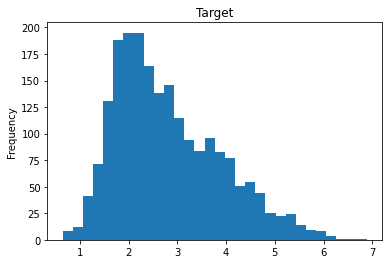

In [ ]:
#We see the distribution of the column in the data 
data['Target'].plot(kind='hist', bins=30, title='Target')
plt.show()

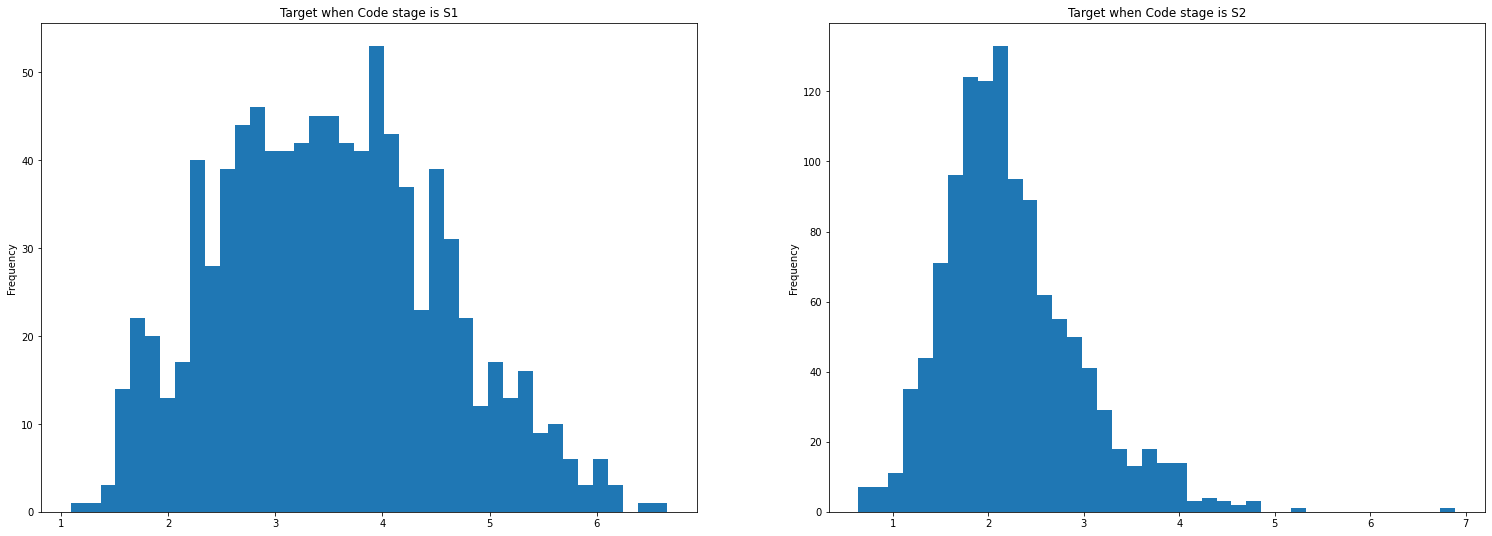

In [ ]:
#We see the distribution of Target taking into account the variables with the most correlation (in modulus)
plt.figure(figsize=(40,9))
plt.subplot(131)
data[data['Code_Stage_S1'] ==1]['Target'].plot(kind='hist', bins=40, title='Target when Code stage is S1')
plt.subplot(132)
data[data['Code_Stage_S2'] ==1]['Target'].plot(kind='hist', bins=40, title='Target when Code stage is S2')
plt.show()


In [ ]:
def plot_create(x, y):
    plt.plot(x, y, '-', label=y.name)
def process_visualisation(df, ID):
    plt.figure(figsize=(14, 6))
    plt.title('Code_Stage_S1 is {}'.format(ID))
    plot_create(df[df['Code_Stage_S1'] ==ID]['Column1'],
                df[df['Code_Stage_S1'] ==ID]['Target'])
    plt.legend()
    plt.ylabel('Value')
    plt.show()

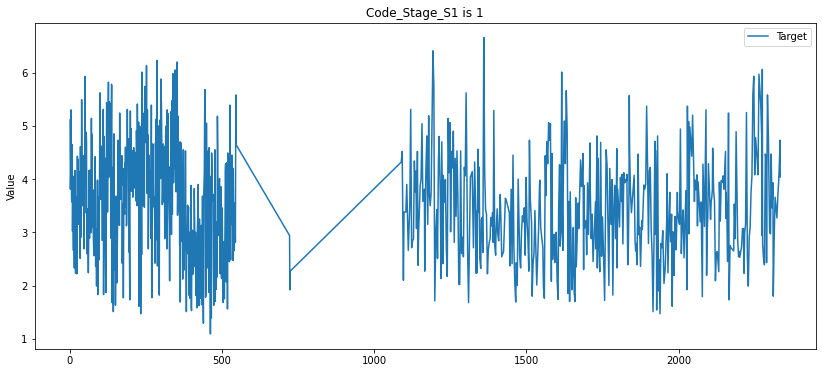

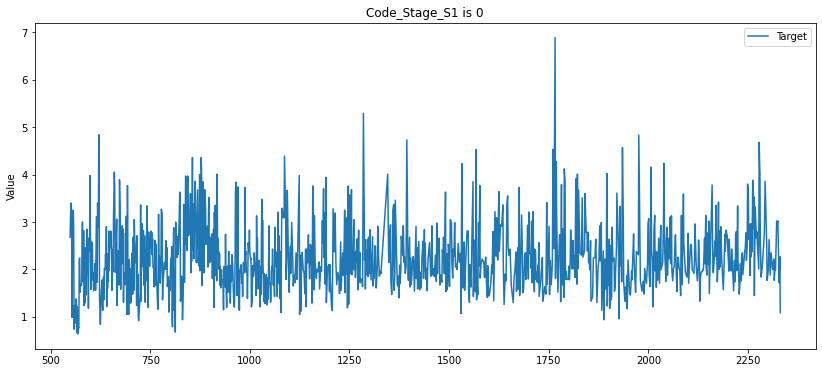

In [ ]:
process_visualisation(data, 1)
process_visualisation(data, 0)


**Train and test section** 

In [ ]:
#We define our dependent and independent variables 
X,X_Kaggle = data,data_test
X = X.drop('Target', axis=1)
X,X_Kaggle = add_features(X),add_features(X_Kaggle)
Y = data['Target']
X=X[[i for i in columns if i!='Target']]
X_Kaggle=X_Kaggle[[i for i in columns_test]]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')
def run_lgb(X_train, Y_train, X_test, Y_test, X_Kaggle):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    lgtrain = lgb.Dataset(X_train, label=Y_train)
    lgval = lgb.Dataset(X_test, label=Y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_Y_Kaggle = model.predict(X_Kaggle, num_iteration=model.best_iteration)
    return pred_Y_Kaggle, model, evals_result

In [ ]:
# Training LGB
pred_test, model, evals_result = run_lgb(X_train, Y_train, X_test, Y_test, X_Kaggle)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 0.821209	valid_1's rmse: 0.906064
[300]	training's rmse: 0.681494	valid_1's rmse: 0.825272
[450]	training's rmse: 0.592053	valid_1's rmse: 0.790002
[600]	training's rmse: 0.526712	valid_1's rmse: 0.773254
[750]	training's rmse: 0.474515	valid_1's rmse: 0.76629
[900]	training's rmse: 0.430012	valid_1's rmse: 0.759818
[1050]	training's rmse: 0.390956	valid_1's rmse: 0.755506
[1200]	training's rmse: 0.357014	valid_1's rmse: 0.752198
[1350]	training's rmse: 0.326686	valid_1's rmse: 0.749426
[1500]	training's rmse: 0.300258	valid_1's rmse: 0.747811
[1650]	training's rmse: 0.27688	valid_1's rmse: 0.746338
[1800]	training's rmse: 0.255869	valid_1's rmse: 0.745151
[1950]	training's rmse: 0.236879	valid_1's rmse: 0.743787
[2100]	training's rmse: 0.219498	valid_1's rmse: 0.743191
[2250]	training's rmse: 0.203855	valid_1's rmse: 0.742569
[2400]	training's rmse: 0.189515	valid_1's rmse: 0.742107
[2550]	training's

In [ ]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:50])

In [ ]:
def run_xgb(X_train, Y_train, X_test, Y_test, X_Kaggle):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    tr_data = xgb.DMatrix(X_train, Y_train)
    va_data = xgb.DMatrix(X_test, Y_test)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(X_Kaggle)
    xgb_pred_Y_Kaggle = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_Y_Kaggle, model_xgb

In [ ]:
# Training XGB
pred_test_xgb, model_xgb = run_xgb(X_train, Y_train, X_test, Y_test, X_Kaggle)
print("XGB Training Completed...")

In [ ]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [ ]:
cb_model.fit(X_train, Y_train,
             eval_set=(X_test, Y_test),
             use_best_model=True,
             verbose=50)

0:	learn: 1.0555743	test: 1.0845497	best: 1.0845497 (0)	total: 158ms	remaining: 1m 18s
50:	learn: 0.6601371	test: 0.8241957	best: 0.8241957 (50)	total: 8.12s	remaining: 1m 11s
100:	learn: 0.5209055	test: 0.7966120	best: 0.7966120 (100)	total: 16s	remaining: 1m 3s
150:	learn: 0.4289148	test: 0.7836066	best: 0.7836066 (150)	total: 23.8s	remaining: 55.1s
200:	learn: 0.3625971	test: 0.7779735	best: 0.7778769 (198)	total: 31.5s	remaining: 46.8s
250:	learn: 0.3020721	test: 0.7738256	best: 0.7738243 (249)	total: 39.2s	remaining: 38.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7734614395
bestIteration = 256

Shrink model to first 257 iterations.


In [ ]:
pred_test_cat= cb_model.predict(X_Kaggle)

In [ ]:
R=pd.DataFrame()
R['Id']=data_test['Column1']
sub_lgb = pd.DataFrame()
sub_lgb["target"] = pred_test

sub_xgb = pd.DataFrame()
sub_xgb["target"] = pred_test_xgb

sub_cat = pd.DataFrame()
sub_cat["target"] = pred_test_cat

R["Target"] = (sub_lgb["target"] * 0.5 + sub_xgb["target"] * 0.3 + sub_cat["target"] * 0.2)

In [ ]:
#We initialize several regression models 
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor(max_depth=100, random_state=0)
catboost_model = CatBoostRegressor(loss_function='RMSE',verbose=0,iterations=4500,learning_rate=0.01)
xgb_model = xgb.XGBRegressor(eta=0.1,min_child_weight=2,colsample_bytree=1,n_estimators=100,normalize_type='forest') 
lgb_model = lightgbm.LGBMRegressor(boosting_type='gbdt', num_leaves=10, max_depth=- 4, learning_rate=0.1, n_estimators=350)
dummy_model = DummyRegressor()
rf_model=RandomForestRegressor(n_estimators=1000,random_state=3,min_samples_leaf=10)

In [ ]:
#A function that calculates the RMSE on a part of the data (testing data)
def train_and_score(model):
    model.fit(X_train, Y_train)
    return np.sqrt(metrics.mean_squared_error(Y_test, model.predict(X_test)))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=0)
display(
    pd.DataFrame(data=([train_and_score(linear_model)],
                       [train_and_score(tree_model)],
                       [train_and_score(catboost_model)],
                       [train_and_score(xgb_model)],
                       [train_and_score(lgb_model)], 
                       [train_and_score(dummy_model)],
                       [train_and_score(rf_model)]
                      ),
                 columns=['Result RMSE'],
                 index=['Linear', 'Tree', 'CatBoost','XGBOOST','LightGBOOST', 'Dummy','Random Forest'])
)

[15:53:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Result RMSE
Linear,0.833271
Tree,1.131641
CatBoost,0.777127
XGBOOST,0.799755
LightGBOOST,0.827176
Dummy,1.133465
Random Forest,0.798486


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

In [ ]:
xgbr = xgb.XGBRegressor(eta=0.1,min_child_weight=2,colsample_bytree=1,n_estimators=350,alpha=0.1) 
print(xgbr)

XGBRegressor(eta=0.1, min_child_weight=2, n_estimators=350)


In [ ]:
xgb_model.fit(X,Y)
Y_Kaggle= xgb_model.predict(X_Kaggle)

[01:22:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
sub_lgb = pd.DataFrame()
sub_lgb["target"] = pred_test

sub_xgb = pd.DataFrame()
sub_xgb["target"] = pred_test_xgb

sub_cat = pd.DataFrame()
sub_cat["target"] = pred_test_cat

In [ ]:
R=pd.DataFrame()
R['Id']=data_test['Column1']
R['Target']=pred_test

In [ ]:
R=R.sort_values(by=['Id'])
R['Id']=R['Id'].astype(int)

In [ ]:

print(statistics.mean(data['Target']))
print(min(data['Target']))
print(max(data['Target']))
print(statistics.stdev(data['Target']))

2.8031059160305345
0.64
6.89
1.0795889079905152


In [ ]:
print(2.827311918014238)
print(1.069901704788208)
print(5.231398582458496)
print(0.8468073288586955)

2.827311918014238
1.069901704788208
5.231398582458496
0.8468073288586955


In [ ]:
print(statistics.mean(R['Target']))
print(min(R['Target']))
print(max(R['Target']))
print(statistics.stdev(R['Target']))

2.7010894863790043
1.5555030335447309
4.611429096752848
0.7383838245439643


In [ ]:
R.to_csv("/content/Classeur).csv",index=False)